SRILM and Wikitext-103 Exploration
===

SRILM is a languauge modeling toolkit that can be downloaded by researchers here: http://www.speech.sri.com/projects/srilm/download.html

Wikitext-103: https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/

In [12]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

SRILM has [documentation](http://www.speech.sri.com/projects/srilm/manpages/ngram-count.1.html) that explains the calls to `ngram-count` in this notebook.

In [58]:
# to use the srilm binary, you'll have to update this path with your own installation of SRILM
srilm_bin = "/home/levon003/bin/srilm/bin/i686-m64"
srilm = srilm_bin + "/ngram-count"
ngram = srilm_bin + "/ngram"

In [5]:
# data is stored relative to the root of the git repository
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/home/levon003/repos/nlp-for-hci-workshop')

In [6]:
wikitext_dir = git_root_dir / 'data' / 'wikitext-103'
train = wikitext_dir / "wiki.train.tokens"
valid = wikitext_dir / "wiki.valid.tokens"
test = wikitext_dir / "wiki.test.tokens"
assert train.exists() and valid.exists() and test.exists()

In [61]:
!wc -l {wikitext_dir}/*.tokens | sort -nr

  1809468 total
  1801350 /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.train.tokens
     4358 /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.test.tokens
     3760 /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.valid.tokens


In [7]:
# Each wikitext-103 file contains tokens separated by whitespace
!head -n 10 {train}

 
 = Valkyria Chronicles III = 
 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . 
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomer

## Counting tokens

In [15]:
!{srilm} -text {train} -write train.n1.count -sort -order 1

In [18]:
!awk '{print $NF" " $0 }' train.n1.count | sort -nr -k1 > train.n1.count.sorted

In [8]:
!head -n 20 train.n1.count.sorted

5584823 the	5584823
4971506 ,	4971506
3624899 .	3624899
2737620 of	2737620
2499539 and	2499539
1979164 to	1979164
1894558 in	1894558
1677048 a	1677048
1466599 =	1466599
1338685 "	1338685
1165029 <s>	1165029
1165029 </s>	1165029
1075325 was	1075325
881576 @-@	881576
853819 The	853819
728291 's	728291
688528 on	688528
679711 that	679711
675287 for	675287
675032 as	675032


In [9]:
# number of words in the vocab!
!wc -l train.n1.count.sorted

267736 train.n1.count.sorted


In [10]:
with open("train.n1.count.sorted") as infile:
    lines = [(int(line.split()[0]), line.split()[1]) for line in infile.readlines()]
    trimmed_lines = [(count, word) for count, word in lines if word.isalpha()]
    counts, words = zip(*trimmed_lines)
assert len(counts) == len(words)
counts[:10]

(5584823,
 2737620,
 2499539,
 1979164,
 1894558,
 1677048,
 1075325,
 853819,
 688528,
 679711)

In [23]:
print(f"{len(counts)} tokens with exclusively alpha characters.")
print("Top 20 tokens and their counts:")
print("(Total percentage of text using only tokens at least this common)")
print("="*27)
total_count = np.sum(counts)
for i in range(20):
    cumulative_percentage_of_counts = np.sum(counts[:i+1]) / total_count * 100
    print(f"{words[i]:6} {counts[i]:>10}  ({cumulative_percentage_of_counts:5.2f}%)")

255356 tokens with exclusively alpha characters.
Top 20 tokens and their counts:
(Total percentage of text using only tokens at least this common)
the       5584823  ( 6.83%)
of        2737620  (10.18%)
and       2499539  (13.23%)
to        1979164  (15.66%)
in        1894558  (17.97%)
a         1677048  (20.02%)
was       1075325  (21.34%)
The        853819  (22.38%)
on         688528  (23.22%)
that       679711  (24.06%)
for        675287  (24.88%)
as         675032  (25.71%)
with       632025  (26.48%)
by         600898  (27.21%)
is         512782  (27.84%)
his        436363  (28.38%)
from       431900  (28.90%)
at         417082  (29.41%)
were       354550  (29.85%)
it         326416  (30.25%)


In [15]:
# by the way, speaking of "his"...
his_count = np.sum(counts[words.index("his")])
her_count = np.sum(counts[words.index("her")]) + np.sum(counts[words.index("hers")])
his_pct = his_count / total_count * 100
her_pct = her_count / total_count * 100
print(f"'his' ({his_pct:.2f}%, {his_count}) is {his_pct / her_pct:.1f}x times more common than 'her'/'hers' ({her_pct:.2f}%, {her_count}). 🤔")

'his' (0.53%, 436363) is 2.5x times more common than 'her'/'hers' (0.22%, 177068). 🤔


In [16]:
# prepare for plotting

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plot_width = 12
plot_height = 8

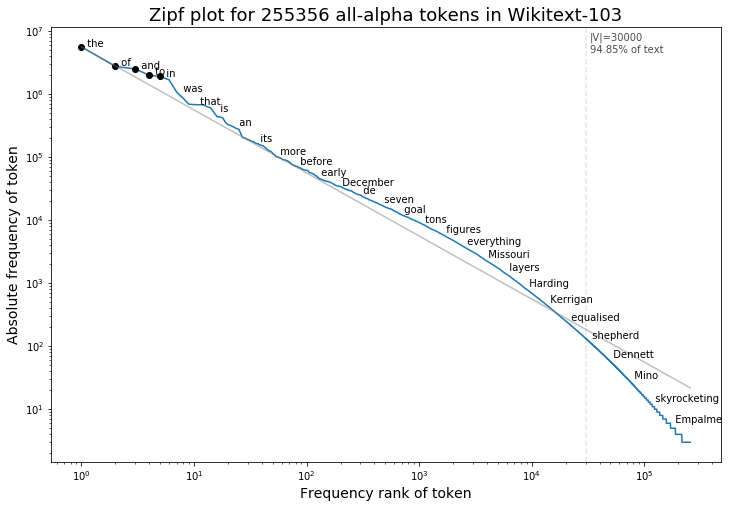

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(plot_width,plot_height))

# plot word rank vs word count
ax.loglog(range(1, len(counts)+1), counts)

# plot the the top 5 words specifically
ax.plot(range(1,6), counts[:5], 'ko')
for i in range(0, 5):
    ax.text(i+1, counts[i], "  " + words[i])
    
# print evenly-spaced sample words from the distribution
for rank in np.geomspace(6, len(counts), endpoint=False, num=25):
    i = int(rank)
    ax.text(i+1, counts[i], "  " + words[i])

# compute and plot the counts if the true distribution was Zipfian
largest = counts[0]
true_zipf = [(1, largest)]
for i in np.geomspace(1, len(counts), endpoint=True, num=25):
    rank = int(i) + 1
    true_zipf.append((rank, largest * 1/rank))
xs, ys = zip(*true_zipf)
ax.plot(xs, ys, color='gray', linestyle='-', alpha=0.5)
    
# label axes and add 30000 line as sample vocab size
plt.axvline(30000, color='black', linestyle='--', alpha=0.1)
pct_of_total_words = np.sum(counts[:30001]) / total_count * 100
plt.text(30000 * 1.1, plt.ylim()[1] * 0.4, f"|V|=30000\n{pct_of_total_words:.2f}% of text", alpha=0.7)
plt.xlabel("Frequency rank of token")
plt.ylabel("Absolute frequency of token")
plt.title(f"Zipf plot for {len(words)} all-alpha tokens in Wikitext-103")
plt.show()

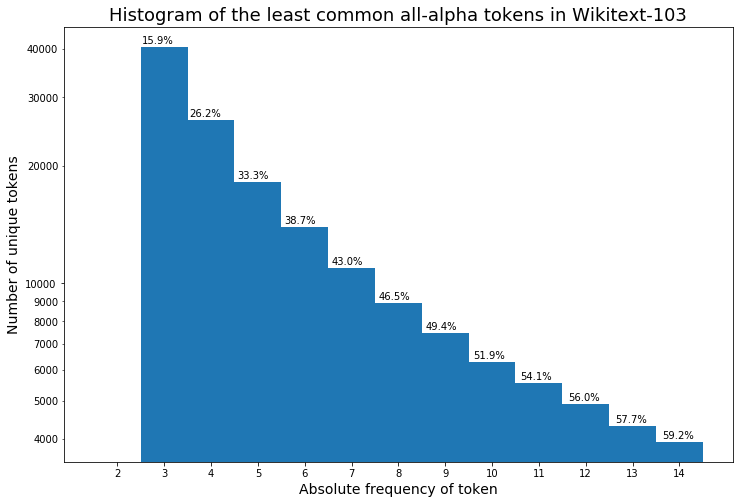

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(plot_width,plot_height))
least_common_words = [count for count in counts if count < 15]
bin_counts, _, _ = ax.hist(least_common_words, log=True, bins=range(2, 16), align='left')

# plot the cumulative percentage of unique words with this number or fewer occurrences
cumulative_total = 0
for i, bin_count in enumerate(bin_counts[1:]):
    cumulative_total += bin_count
    pct = cumulative_total / len(words)
    ax.text((i + 3) * 1.01 - 0.5, bin_count * 1.02, f"{pct*100:.1f}%")

from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
plt.xticks(range(2,15))
plt.xlabel("Absolute frequency of token")
plt.ylabel("Number of unique tokens")
plt.title(f"Histogram of the least common all-alpha tokens in Wikitext-103")
plt.show()

### $n$-grams

Moving beyond individual unigram tokens.

In [213]:
# compute wikitext counts for bigrams and trigrams
!{srilm} -text {train} -write train.n2.count -sort -order 2
!awk '{print $NF" " $0 }' train.n2.count | sort -nr -k1 > train.n2.count.sorted
!{srilm} -text {train} -write train.n3.count -sort -order 3
!awk '{print $NF" " $0 }' train.n3.count | sort -nr -k1 > train.n3.count.sorted

In [25]:
# each counts file contains all lower-order n-grams as well
!wc -l *.count.sorted | sort -nr

  63554045 total
  51977781 train.n3.count.sorted
  11308528 train.n2.count.sorted
    267736 train.n1.count.sorted


In [54]:
# we grab 20 random lines from the top 20000 lines in the bigram counts file
!head -n 20000 train.n2.count.sorted | shuf -n 20 | sort -nr

12991 list	12991
9248 cm	9248
4501 the field	4501
3329 what he	3329
2728 victories	2728
2114 be made	2114
2057 house .	2057
1867 take place	1867
1664 , creating	1664
1664 a 5	1664
1626 retail	1626
1413 aftermath of	1413
1292 in 1980	1292
1202 white ,	1202
1132 will have	1132
1091 gather	1091
1049 20 .	1049
885 to publish	885
867 claim to	867
849 and told	849


In [26]:
with open("train.n2.count.sorted") as infile:
    lines = [(int(line.split()[0]), line.split()[1:-1]) for line in infile.readlines()]

In [33]:
bigram_counts, bigram_words = [], []
for count, words in lines:
    if len(words) == 1:
        continue  # skip unigram counts
    bigram_counts.append(count)
    bigram_words.append(" ".join(words))
len(bigram_counts)

11040792

In [38]:
total_bigram_counts = np.sum(bigram_counts)
total_bigram_counts, f"{total_bigram_counts / total_count * 100:.2f}% of total unigram occurrences"

(102590700, '125.46% of total unigram occurrences')

In [43]:
# Words that most frequently follow a header or subsection header
words_printed = 0
for i in range(len(bigram_counts)):
    if words_printed > 20:
        break
    words = bigram_words[i]
    if words.startswith("= "):
        print(f"{words[2:]:20} {bigram_counts[i]:7}")
        words_printed += 1

=                     854175
</s>                  305503
History                 6415
Early                   5873
Background              5818
Reception               5387
The                     3715
Production              3641
Plot                    3599
Critical                2840
Release                 2720
<unk>                   2482
Music                   2374
Development             2160
Legacy                  2094
Other                   1980
Track                   1822
Aftermath               1813
Description             1749
Personal                1708
Charts                  1668


In [46]:
# Words that most frequently start a paragraph
words_printed = 0
for i in range(len(bigram_counts)):
    if words_printed > 20:
        break
    words = bigram_words[i]
    if words.startswith("<s> "):
        print(f"{words[4:]:20} {bigram_counts[i]:7}")
        words_printed += 1

=                     305497
The                   160302
In                     78200
On                     24380
"                      23790
A                      15990
After                  15071
As                     10647
During                  9431
At                      8907
<unk>                   7755
When                    6080
By                      6026
Although                5478
Following               5244
There                   5014
While                   4945
According               4423
With                    3989
For                     3979
It                      3856


## Language Modeling

In [89]:
!{srilm} -text {train} -order 3 -addsmooth 1 -lm train.lm &> /dev/null
!wc -l train.lm

20582151 train.lm


In [90]:
!head -n 20 train.lm


\data\
ngram 1=267735
ngram 2=10971579
ngram 3=9342824

\1-grams:
-3.411519	!	-0.6342278
-2.237392	"	-0.1060671
-4.124262	#	-0.6762458
-3.881232	$	-0.9501724
-4.427027	%	-0.532291
-3.388234	&	-0.1964037
-2.760494	'	-0.2205092
-6.609695	'A	-0.2153656
-6.551673	'Abbadie	-0.1433707
-6.551673	'Abbetot	-0.1456759
-6.551673	'Abetot	-0.1251051
-6.551673	'Abitot	-0.1301055
-6.551673	'Abitots	-0.1414997


In [101]:
!grep -P "\tthe" train.lm | head -n 1
!grep -P "\tKerrigan" train.lm | head -n 1
!grep -P "\tNew York City" train.lm | head -n 1

-2.56756	the	-0.264325
grep: write error: Broken pipe
-4.959892	Kerrigan	-0.33821
grep: write error: Broken pipe
-0.7623988	New York City


In [94]:
# occurrence of 'the' = 0.27%
10 ** -2.56756

0.002706699233770596

In [98]:
# occurrence of 'Kerrigan'
10 ** -4.959892

1.096750901359553e-05

In [102]:
# What % of the time does "City" follow "New" + "York"?
10 ** -0.7623988

0.1728228648215396

In [99]:
!{ngram} -lm train.lm -ppl {valid}

file /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.valid.tokens: 2461 sentences, 213886 words, 1657 OOVs
0 zeroprobs, logprob= -474960.2 ppl= 163.0448 ppl1= 172.966


In [100]:
!{ngram} -lm train.lm -ppl {valid} -debug 2 | head -n 155

reading 267735 1-grams
reading 10971579 2-grams
reading 9342824 3-grams
= Homarus gammarus =
	p( = | <s> ) 	= [2gram] 0.2639786 [ -0.5784313 ]
	p( Homarus | = ...) 	= [1gram] 2.454183e-08 [ -7.610093 ]
	p( gammarus | Homarus ...) 	= [2gram] 0.1036962 [ -0.9842371 ]
	p( = | gammarus ...) 	= [1gram] 0.002002014 [ -2.698533 ]
	p( </s> | = ...) 	= [2gram] 0.1861666 [ -0.7300982 ]
1 sentences, 4 words, 0 OOVs
0 zeroprobs, logprob= -12.60139 ppl= 331.3435 ppl1= 1413.67

Homarus gammarus , known as the European lobster or common lobster , is a species of clawed lobster from the eastern Atlantic Ocean , Mediterranean Sea and parts of the Black Sea . It is closely related to the American lobster , H. americanus . It may grow to a length of 60 cm ( 24 in ) and a mass of 6 kilograms ( 13 lb ) , and bears a conspicuous pair of claws . In life , the lobsters are blue , only becoming " lobster red " on cooking . Mating occurs in the summer , producing eggs which are carried by the females for up to 

### Smoothing

Assign probability to OOV tokens.

In [111]:
# Kneser-Ney
!{srilm} -text {train} -order 3 -kndiscount -lm train_kn.lm
!{ngram} -lm train_kn.lm -ppl {valid}

file /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.valid.tokens: 2461 sentences, 213886 words, 1657 OOVs
0 zeroprobs, logprob= -474960.2 ppl= 163.0448 ppl1= 172.966


In [112]:
# Witten-Bell
!{srilm} -text {train} -order 3 -wbdiscount -lm train_wb.lm
!{ngram} -lm train_wb.lm -ppl {valid}

file /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.valid.tokens: 2461 sentences, 213886 words, 1657 OOVs
0 zeroprobs, logprob= -477925.2 ppl= 168.3129 ppl1= 178.6206


In [113]:
# Witten-Bell (bigrams only)
!{srilm} -text {train} -order 2 -wbdiscount -lm train_wb2.lm
!{ngram} -lm train_wb2.lm -ppl {valid}

file /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.valid.tokens: 2461 sentences, 213886 words, 1657 OOVs
0 zeroprobs, logprob= -523069.6 ppl= 273.146 ppl1= 291.5058


In [114]:
# We'll use the best LM we trained to evaluate on the test dataset
!{ngram} -lm train_kn.lm -ppl {test}

file /home/levon003/repos/nlp-for-hci-workshop/data/wikitext-103/wiki.test.tokens: 2891 sentences, 241211 words, 2492 OOVs
0 zeroprobs, logprob= -540165.5 ppl= 172.0647 ppl1= 183.1332


Not bad!

The LM is about as confused as if we were rolling a 172-sided die.

Graves et al. achieve a perplexity of 40.8, and [published best](https://nlpprogress.com/english/language_modeling.html) is as low as 20 (!!). When it comes to language modeling, word counting is not enough.  (We really need to use more context and recognize similar situations.)